## Timeseries clustering

Time series clustering is to partition time series data into groups based on similarity or distance, so that time series in the same cluster are similar.

Methodology followed:
* Use Variational Recurrent AutoEncoder (VRAE) for dimensionality reduction of the timeseries
* To visualize the clusters, PCA and t-sne are used

Paper:
https://arxiv.org/pdf/1412.6581.pdf

#### Contents

0. [Load data and preprocess](#Load-data-and-preprocess)
1. [Initialize VRAE object](#Initialize-VRAE-object)
2. [Fit the model onto dataset](#Fit-the-model-onto-dataset)
3. [Transform the input timeseries to encoded latent vectors](#Transform-the-input-timeseries-to-encoded-latent-vectors)
4. [Save the model to be fetched later](#Save-the-model-to-be-fetched-later)
5. [Visualize using PCA and tSNE](#Visualize-using-PCA-and-tSNE)

In [201]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

### Import required modules

In [229]:
from vrae.vrae import VRAE
from vrae.utils import *
import numpy as np
import torch
import pickle

import plotly
from torch.utils.data import DataLoader, TensorDataset
plotly.offline.init_notebook_mode()

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Input parameters

In [230]:
dload = './model_dir' #download directory

### Hyper parameters

In [231]:
seq_len = 10
hidden_size = 256
hidden_layer_depth = 3
latent_length = 64
batch_size = 32
learning_rate = 0.00002
n_epochs = 3000
dropout_rate = 0.0
optimizer = 'Adam' # options: ADAM, SGD
cuda = True # options: True, False
print_every=500
clip = True # options: True, False
max_grad_norm=5
loss = 'MSELoss' # options: SmoothL1Loss, MSELoss
block = 'LSTM' # options: LSTM, GRU

### Load data and preprocess

In [232]:
X_train, X_val, y_train, y_val = open_data('data', ratio_train=1.0, dataset='EMG', filename = "EMGe5_len10")

# Data is sequential, so we need to reshape it to add a time dimension
X_train = X_train.reshape(X_train.shape[0], seq_len, -1)

# cut the last several segments to match batch size
num_seg = (X_train.shape[0] // batch_size) * batch_size
X_train = X_train[:num_seg, :, :]
print(X_train.shape)

# For learning embeddings, we don't care about overfitting
X_val = X_train

train_dataset = TensorDataset(torch.from_numpy(X_train))
test_dataset = TensorDataset(torch.from_numpy(X_train))

(21568, 10, 15)


In [233]:
num_classes = len(np.unique(y_train))
base = np.min(y_train)  # Check if data is 0-based
if base != 0:
    y_train -= base
#y_val -= base
y_train = y_train[:num_seg, :]
y_val = y_train

**Fetch `number_of_features` from dataset**

This config corresponds to number of input features

In [235]:
number_of_features = X_train.shape[2]

### Initialize VRAE object

VRAE inherits from `sklearn.base.BaseEstimator` and overrides `fit`, `transform` and `fit_transform` functions, similar to sklearn modules

In [236]:
vrae = VRAE(sequence_length=seq_len,
            number_of_features = number_of_features,
            hidden_size = hidden_size, 
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            optimizer = optimizer, 
            cuda = cuda,
            print_every=print_every, 
            clip=clip, 
            max_grad_norm=max_grad_norm,
            loss = loss,
            block = block,
            dload = dload)

### Fit the model onto dataset

In [237]:
#vrae.fit(train_dataset)

#If the model has to be saved, with the learnt parameters use:
vrae.fit(train_dataset)

Epoch: 0
Average loss: 10196588.7994
Epoch: 1
Average loss: 8813701.7303
Epoch: 2
Average loss: 8067542.2741
Epoch: 3
Average loss: 7447466.3815
Epoch: 4
Average loss: 6941800.5409
Epoch: 5
Average loss: 6535840.2834
Epoch: 6
Average loss: 6218952.2541
Epoch: 7
Average loss: 5979418.1620
Epoch: 8
Average loss: 5806423.6924
Epoch: 9
Average loss: 5686549.0966
Epoch: 10
Average loss: 5605526.5420
Epoch: 11
Average loss: 5554698.8897
Epoch: 12
Average loss: 5525613.3815
Epoch: 13
Average loss: 5510164.6809
Epoch: 14
Average loss: 5155858.1237
Epoch: 15
Average loss: 4651756.9058
Epoch: 16
Average loss: 4471277.4391
Epoch: 17
Average loss: 4287569.0193
Epoch: 18
Average loss: 4106194.3991
Epoch: 19
Average loss: 3930809.1350
Epoch: 20
Average loss: 3755145.8663
Epoch: 21
Average loss: 3591915.7240
Epoch: 22
Average loss: 3439677.3111
Epoch: 23
Average loss: 3291599.7987
Epoch: 24
Average loss: 3154238.9199
Epoch: 25
Average loss: 3027609.4929
Epoch: 26
Average loss: 2903497.5893
Epoch: 27


Average loss: 297814.2309
Epoch: 224
Average loss: 296608.0549
Epoch: 225
Average loss: 295568.6228
Epoch: 226
Average loss: 294373.1933
Epoch: 227
Average loss: 293309.8580
Epoch: 228
Average loss: 291982.3921
Epoch: 229
Average loss: 290769.8174
Epoch: 230
Average loss: 289483.5476
Epoch: 231
Average loss: 288207.3309
Epoch: 232
Average loss: 287033.7703
Epoch: 233
Average loss: 285784.5226
Epoch: 234
Average loss: 284573.1099
Epoch: 235
Average loss: 283250.9821
Epoch: 236
Average loss: 282174.4030
Epoch: 237
Average loss: 281237.3337
Epoch: 238
Average loss: 280007.9048
Epoch: 239
Average loss: 278959.3138
Epoch: 240
Average loss: 277672.7752
Epoch: 241
Average loss: 276600.9878
Epoch: 242
Average loss: 275761.3258
Epoch: 243
Average loss: 274561.4981
Epoch: 244
Average loss: 273468.7473
Epoch: 245
Average loss: 272499.9541
Epoch: 246
Average loss: 271411.7016
Epoch: 247
Average loss: 270483.1579
Epoch: 248
Average loss: 269500.6461
Epoch: 249
Average loss: 268506.7694
Epoch: 250
A

Average loss: 164218.9337
Epoch: 446
Average loss: 163981.9605
Epoch: 447
Average loss: 163699.6686
Epoch: 448
Average loss: 163417.6685
Epoch: 449
Average loss: 163193.1329
Epoch: 450
Average loss: 162869.0813
Epoch: 451
Average loss: 162711.1660
Epoch: 452
Average loss: 162304.0929
Epoch: 453
Average loss: 161984.6837
Epoch: 454
Average loss: 161745.8124
Epoch: 455
Average loss: 161408.4949
Epoch: 456
Average loss: 161164.1494
Epoch: 457
Average loss: 160821.0526
Epoch: 458
Average loss: 160580.6353
Epoch: 459
Average loss: 160384.1490
Epoch: 460
Average loss: 160091.4484
Epoch: 461
Average loss: 159799.4169
Epoch: 462
Average loss: 159520.2782
Epoch: 463
Average loss: 159252.0802
Epoch: 464
Average loss: 159017.9476
Epoch: 465
Average loss: 158675.5646
Epoch: 466
Average loss: 158414.2119
Epoch: 467
Average loss: 158170.5110
Epoch: 468
Average loss: 157847.6650
Epoch: 469
Average loss: 157566.9815
Epoch: 470
Average loss: 157325.6080
Epoch: 471
Average loss: 157089.8102
Epoch: 472
A

Average loss: 114547.0472
Epoch: 668
Average loss: 114447.8556
Epoch: 669
Average loss: 114295.1356
Epoch: 670
Average loss: 114101.5210
Epoch: 671
Average loss: 113945.4620
Epoch: 672
Average loss: 113840.0096
Epoch: 673
Average loss: 113680.0045
Epoch: 674
Average loss: 113530.8139
Epoch: 675
Average loss: 113427.7685
Epoch: 676
Average loss: 113199.5549
Epoch: 677
Average loss: 113140.0566
Epoch: 678
Average loss: 112968.0258
Epoch: 679
Average loss: 112814.8972
Epoch: 680
Average loss: 112649.5168
Epoch: 681
Average loss: 112494.3989
Epoch: 682
Average loss: 112421.0046
Epoch: 683
Average loss: 112240.7155
Epoch: 684
Average loss: 112122.1236
Epoch: 685
Average loss: 112071.8892
Epoch: 686
Average loss: 111870.6313
Epoch: 687
Average loss: 111721.3152
Epoch: 688
Average loss: 111565.6239
Epoch: 689
Average loss: 111430.3676
Epoch: 690
Average loss: 111361.5139
Epoch: 691
Average loss: 111191.5918
Epoch: 692
Average loss: 111007.2674
Epoch: 693
Average loss: 110834.9904
Epoch: 694
A

Average loss: 88830.7166
Epoch: 893
Average loss: 88805.8987
Epoch: 894
Average loss: 88683.7538
Epoch: 895
Average loss: 88601.6702
Epoch: 896
Average loss: 88517.9449
Epoch: 897
Average loss: 88415.5726
Epoch: 898
Average loss: 88395.5138
Epoch: 899
Average loss: 88283.5890
Epoch: 900
Average loss: 88163.7028
Epoch: 901
Average loss: 88110.5726
Epoch: 902
Average loss: 88009.9184
Epoch: 903
Average loss: 87923.5908
Epoch: 904
Average loss: 87765.9785
Epoch: 905
Average loss: 87674.7458
Epoch: 906
Average loss: 87664.6968
Epoch: 907
Average loss: 87530.5892
Epoch: 908
Average loss: 87431.0791
Epoch: 909
Average loss: 87390.8848
Epoch: 910
Average loss: 87289.2585
Epoch: 911
Average loss: 87192.1829
Epoch: 912
Average loss: 87109.5002
Epoch: 913
Average loss: 87033.7923
Epoch: 914
Average loss: 86969.5894
Epoch: 915
Average loss: 86885.2005
Epoch: 916
Average loss: 86785.9527
Epoch: 917
Average loss: 86661.7241
Epoch: 918
Average loss: 86588.3811
Epoch: 919
Average loss: 86533.6711
Epo

Average loss: 72183.9165
Epoch: 1118
Average loss: 72206.9438
Epoch: 1119
Average loss: 72100.4328
Epoch: 1120
Average loss: 72061.4835
Epoch: 1121
Average loss: 71951.2955
Epoch: 1122
Average loss: 71925.0663
Epoch: 1123
Average loss: 71831.1698
Epoch: 1124
Average loss: 71787.4897
Epoch: 1125
Average loss: 71747.9957
Epoch: 1126
Average loss: 71718.9519
Epoch: 1127
Average loss: 71615.2610
Epoch: 1128
Average loss: 71516.2543
Epoch: 1129
Average loss: 71533.4430
Epoch: 1130
Average loss: 71418.7895
Epoch: 1131
Average loss: 71391.6061
Epoch: 1132
Average loss: 71322.3023
Epoch: 1133
Average loss: 71241.4659
Epoch: 1134
Average loss: 71216.9266
Epoch: 1135
Average loss: 71116.5649
Epoch: 1136
Average loss: 71070.4112
Epoch: 1137
Average loss: 70994.6653
Epoch: 1138
Average loss: 70953.7531
Epoch: 1139
Average loss: 70886.2999
Epoch: 1140
Average loss: 70857.3384
Epoch: 1141
Average loss: 70784.1274
Epoch: 1142
Average loss: 70749.9542
Epoch: 1143
Average loss: 70675.2879
Epoch: 1144
A

Average loss: 61575.5435
Epoch: 1340
Average loss: 61544.2509
Epoch: 1341
Average loss: 61514.5068
Epoch: 1342
Average loss: 61506.4013
Epoch: 1343
Average loss: 61396.3784
Epoch: 1344
Average loss: 61391.3080
Epoch: 1345
Average loss: 61356.3699
Epoch: 1346
Average loss: 61319.9517
Epoch: 1347
Average loss: 61248.0876
Epoch: 1348
Average loss: 61239.8309
Epoch: 1349
Average loss: 61191.4398
Epoch: 1350
Average loss: 61154.7957
Epoch: 1351
Average loss: 61105.3654
Epoch: 1352
Average loss: 61110.1010
Epoch: 1353
Average loss: 61056.8845
Epoch: 1354
Average loss: 61021.9740
Epoch: 1355
Average loss: 60953.5982
Epoch: 1356
Average loss: 60969.2315
Epoch: 1357
Average loss: 60913.1363
Epoch: 1358
Average loss: 60877.4377
Epoch: 1359
Average loss: 60833.7210
Epoch: 1360
Average loss: 60803.0988
Epoch: 1361
Average loss: 60751.6360
Epoch: 1362
Average loss: 60709.3380
Epoch: 1363
Average loss: 60728.9724
Epoch: 1364
Average loss: 60640.7341
Epoch: 1365
Average loss: 60604.4079
Epoch: 1366
A

Epoch: 1561
Average loss: 54073.0147
Epoch: 1562
Average loss: 54071.1464
Epoch: 1563
Average loss: 54044.7017
Epoch: 1564
Average loss: 54029.0009
Epoch: 1565
Average loss: 53955.6995
Epoch: 1566
Average loss: 53952.9613
Epoch: 1567
Average loss: 53961.5803
Epoch: 1568
Average loss: 53892.9663
Epoch: 1569
Average loss: 53867.8890
Epoch: 1570
Average loss: 53808.1257
Epoch: 1571
Average loss: 53777.3651
Epoch: 1572
Average loss: 53770.6040
Epoch: 1573
Average loss: 53749.8145
Epoch: 1574
Average loss: 53696.6965
Epoch: 1575
Average loss: 53662.6164
Epoch: 1576
Average loss: 53670.0991
Epoch: 1577
Average loss: 53611.3851
Epoch: 1578
Average loss: 53594.4977
Epoch: 1579
Average loss: 53599.4018
Epoch: 1580
Average loss: 53543.6761
Epoch: 1581
Average loss: 53526.4600
Epoch: 1582
Average loss: 53491.5862
Epoch: 1583
Average loss: 53460.9127
Epoch: 1584
Average loss: 53425.9987
Epoch: 1585
Average loss: 53382.1837
Epoch: 1586
Average loss: 53359.6848
Epoch: 1587
Average loss: 53352.9071
E

Average loss: 48269.8280
Epoch: 1784
Average loss: 48278.2387
Epoch: 1785
Average loss: 48220.8127
Epoch: 1786
Average loss: 48241.5075
Epoch: 1787
Average loss: 48229.8171
Epoch: 1788
Average loss: 48156.7814
Epoch: 1789
Average loss: 48130.7449
Epoch: 1790
Average loss: 48098.9759
Epoch: 1791
Average loss: 48103.7116
Epoch: 1792
Average loss: 48050.7162
Epoch: 1793
Average loss: 48034.2048
Epoch: 1794
Average loss: 48029.4063
Epoch: 1795
Average loss: 47965.7957
Epoch: 1796
Average loss: 47974.0083
Epoch: 1797
Average loss: 47954.6792
Epoch: 1798
Average loss: 47921.8747
Epoch: 1799
Average loss: 47851.5505
Epoch: 1800
Average loss: 47875.1041
Epoch: 1801
Average loss: 47839.9130
Epoch: 1802
Average loss: 47850.9163
Epoch: 1803
Average loss: 47862.6184
Epoch: 1804
Average loss: 47780.5970
Epoch: 1805
Average loss: 47772.4504
Epoch: 1806
Average loss: 47770.0747
Epoch: 1807
Average loss: 47720.7387
Epoch: 1808
Average loss: 47701.8531
Epoch: 1809
Average loss: 47689.3692
Epoch: 1810
A

Average loss: 43625.3698
Epoch: 2006
Average loss: 43577.4071
Epoch: 2007
Average loss: 43571.9123
Epoch: 2008
Average loss: 43561.4296
Epoch: 2009
Average loss: 43518.6292
Epoch: 2010
Average loss: 43492.3173
Epoch: 2011
Average loss: 43494.9767
Epoch: 2012
Average loss: 43487.5157
Epoch: 2013
Average loss: 43453.5886
Epoch: 2014
Average loss: 43417.1501
Epoch: 2015
Average loss: 43441.7637
Epoch: 2016
Average loss: 43453.8675
Epoch: 2017
Average loss: 43409.2332
Epoch: 2018
Average loss: 43356.0824
Epoch: 2019
Average loss: 43332.2956
Epoch: 2020
Average loss: 43327.5745
Epoch: 2021
Average loss: 43287.3847
Epoch: 2022
Average loss: 43305.4201
Epoch: 2023
Average loss: 43292.3843
Epoch: 2024
Average loss: 43217.4734
Epoch: 2025
Average loss: 43223.2835
Epoch: 2026
Average loss: 43249.1290
Epoch: 2027
Average loss: 43205.3435
Epoch: 2028
Average loss: 43135.7247
Epoch: 2029
Average loss: 43151.5757
Epoch: 2030
Average loss: 43131.7332
Epoch: 2031
Average loss: 43147.4690
Epoch: 2032
A

Average loss: 39755.6507
Epoch: 2228
Average loss: 39713.9519
Epoch: 2229
Average loss: 39747.6851
Epoch: 2230
Average loss: 39681.9705
Epoch: 2231
Average loss: 39726.3022
Epoch: 2232
Average loss: 39682.5694
Epoch: 2233
Average loss: 39648.3790
Epoch: 2234
Average loss: 39632.8061
Epoch: 2235
Average loss: 39649.8161
Epoch: 2236
Average loss: 39568.1729
Epoch: 2237
Average loss: 39598.2590
Epoch: 2238
Average loss: 39596.4898
Epoch: 2239
Average loss: 39554.2362
Epoch: 2240
Average loss: 39572.9790
Epoch: 2241
Average loss: 39491.3529
Epoch: 2242
Average loss: 39512.4015
Epoch: 2243
Average loss: 39493.9022
Epoch: 2244
Average loss: 39448.2674
Epoch: 2245
Average loss: 39466.3808
Epoch: 2246
Average loss: 39432.9157
Epoch: 2247
Average loss: 39431.8506
Epoch: 2248
Average loss: 39442.0991
Epoch: 2249
Average loss: 39397.4040
Epoch: 2250
Average loss: 39387.7316
Epoch: 2251
Average loss: 39397.7408
Epoch: 2252
Average loss: 39365.1563
Epoch: 2253
Average loss: 39320.8989
Epoch: 2254
A

Average loss: 36567.0787
Epoch: 2450
Average loss: 36492.9789
Epoch: 2451
Average loss: 36484.6710
Epoch: 2452
Average loss: 36474.6326
Epoch: 2453
Average loss: 36450.8142
Epoch: 2454
Average loss: 36483.1427
Epoch: 2455
Average loss: 36460.4517
Epoch: 2456
Average loss: 36445.4922
Epoch: 2457
Average loss: 36423.6584
Epoch: 2458
Average loss: 36409.2155
Epoch: 2459
Average loss: 36468.8423
Epoch: 2460
Average loss: 36386.0890
Epoch: 2461
Average loss: 36377.2815
Epoch: 2462
Average loss: 36349.9690
Epoch: 2463
Average loss: 36325.8233
Epoch: 2464
Average loss: 36325.1349
Epoch: 2465
Average loss: 36283.3951
Epoch: 2466
Average loss: 36288.4894
Epoch: 2467
Average loss: 36293.4885
Epoch: 2468
Average loss: 36288.6981
Epoch: 2469
Average loss: 36242.5185
Epoch: 2470
Average loss: 36251.4616
Epoch: 2471
Average loss: 36214.1302
Epoch: 2472
Average loss: 36245.8786
Epoch: 2473
Average loss: 36209.3759
Epoch: 2474
Average loss: 36179.8872
Epoch: 2475
Average loss: 36160.1372
Epoch: 2476
A

Epoch: 2671
Average loss: 33803.0088
Epoch: 2672
Average loss: 33786.7276
Epoch: 2673
Average loss: 33778.0690
Epoch: 2674
Average loss: 33763.3592
Epoch: 2675
Average loss: 33752.2813
Epoch: 2676
Average loss: 33775.3250
Epoch: 2677
Average loss: 33727.4048
Epoch: 2678
Average loss: 33704.1831
Epoch: 2679
Average loss: 33734.7390
Epoch: 2680
Average loss: 33677.6107
Epoch: 2681
Average loss: 33688.0812
Epoch: 2682
Average loss: 33680.9034
Epoch: 2683
Average loss: 33655.2899
Epoch: 2684
Average loss: 33662.9600
Epoch: 2685
Average loss: 33645.9785
Epoch: 2686
Average loss: 33616.9216
Epoch: 2687
Average loss: 33618.6063
Epoch: 2688
Average loss: 33626.2296
Epoch: 2689
Average loss: 33611.5065
Epoch: 2690
Average loss: 33566.1157
Epoch: 2691
Average loss: 33536.3567
Epoch: 2692
Average loss: 33552.6520
Epoch: 2693
Average loss: 33548.6385
Epoch: 2694
Average loss: 33574.5303
Epoch: 2695
Average loss: 33519.7010
Epoch: 2696
Average loss: 33498.4127
Epoch: 2697
Average loss: 33482.0427
E

Average loss: 31434.2710
Epoch: 2894
Average loss: 31402.4177
Epoch: 2895
Average loss: 31381.1831
Epoch: 2896
Average loss: 31445.6573
Epoch: 2897
Average loss: 31417.5089
Epoch: 2898
Average loss: 31373.3573
Epoch: 2899
Average loss: 31397.6376
Epoch: 2900
Average loss: 31367.5853
Epoch: 2901
Average loss: 31367.0597
Epoch: 2902
Average loss: 31388.7630
Epoch: 2903
Average loss: 31332.1886
Epoch: 2904
Average loss: 31330.5706
Epoch: 2905
Average loss: 31347.2105
Epoch: 2906
Average loss: 31339.6591
Epoch: 2907
Average loss: 31313.5158
Epoch: 2908
Average loss: 31312.6085
Epoch: 2909
Average loss: 31301.4684
Epoch: 2910
Average loss: 31260.9426
Epoch: 2911
Average loss: 31283.5855
Epoch: 2912
Average loss: 31236.8776
Epoch: 2913
Average loss: 31248.4237
Epoch: 2914
Average loss: 31249.4372
Epoch: 2915
Average loss: 31246.0160
Epoch: 2916
Average loss: 31203.4408
Epoch: 2917
Average loss: 31226.3867
Epoch: 2918
Average loss: 31169.3262
Epoch: 2919
Average loss: 31162.6005
Epoch: 2920
A

### Plot loss

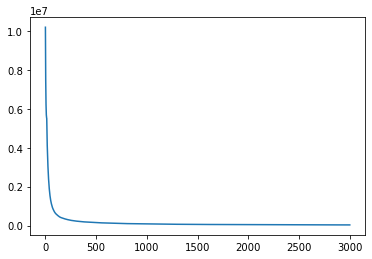

In [238]:
plt.plot(vrae.all_loss)

### Transform the input timeseries to encoded latent vectors

In [239]:
#If the latent vectors have to be saved, pass the parameter `save`
z_run = vrae.transform(train_dataset, save = True, filename = 'z_run_e5_3000epoch.pkl')
z_run.shape

(21568, 64)

### Save / load the model

In [240]:
vrae.save('./vrae_e5_3000epoch.pth')

In [218]:
vrae.load(dload+'/vrae_3_10000epoch.pth')
with open(dload+'/z_run.pkl', 'rb') as fh:
    z_run = pickle.load(fh)

### Reconstruction

In [241]:
reconstruction = vrae.reconstruct(train_dataset)
reconstruction = reconstruction.transpose((1,0,2))

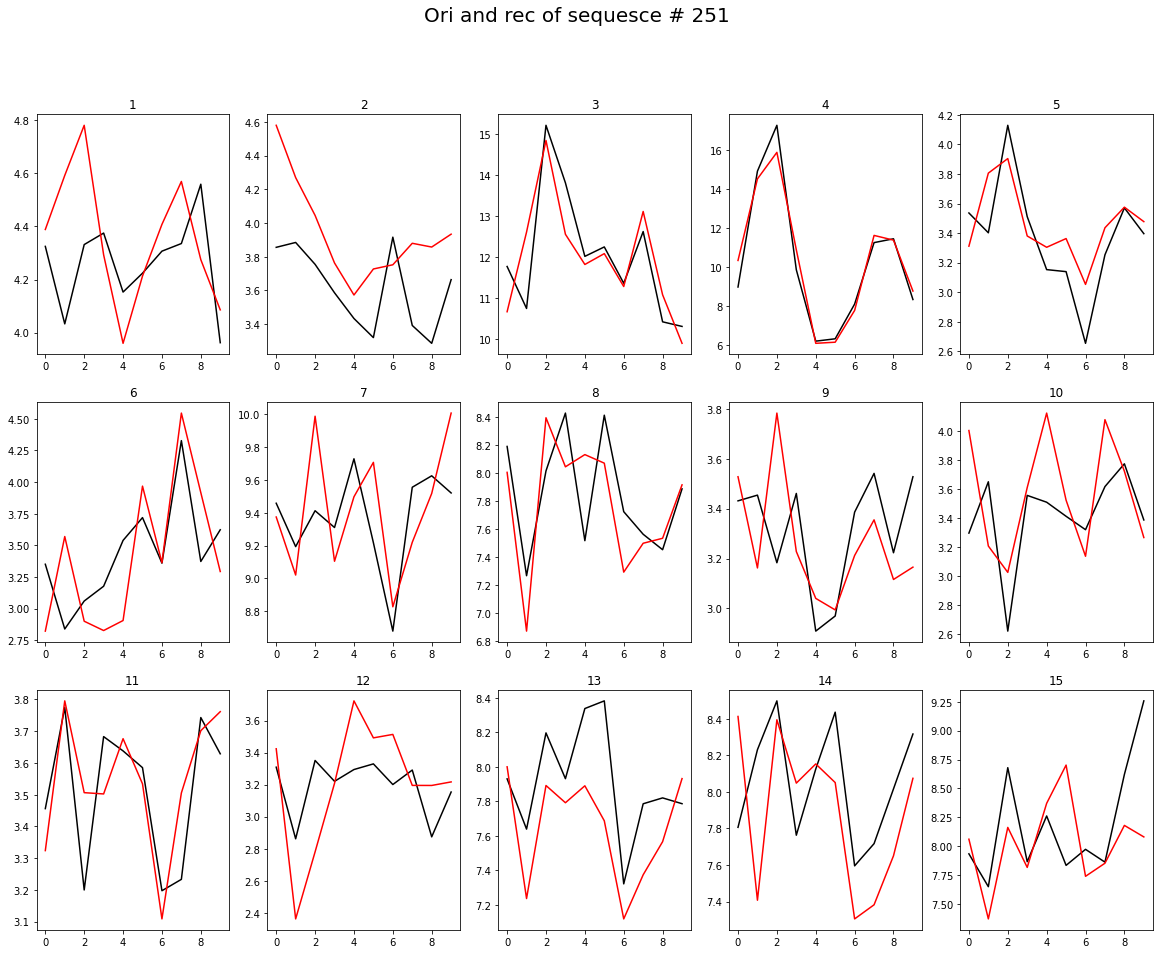

In [247]:
# Show one reconstruction

num_seq = reconstruction.shape[0]

fig, axs = plt.subplots(3, 5, figsize = (20, 15))
# idx = np.random.choice(num_seq, 1)[0]
idx = 250

for ii in range(number_of_features):
    ori = X_train[idx, :, ii]
    rec = reconstruction[idx, :, ii]
    axs[ii//5, ii%5].plot(ori, color = 'black')
    axs[ii//5, ii%5].plot(rec, color = 'red')
    axs[ii//5, ii%5].set_title(ii+1)
fig.suptitle(f'Ori and rec of sequesce # {idx+1}', size = 20)
plt.show()
    

In [243]:
corr = []
num_seq
for ii in range(number_of_features):
    temp = []
    for jj in range(num_seq):
        corr_temp = np.corrcoef(reconstruction[jj, :, ii], X_train[jj, :, ii])[0,1]
        temp.append(corr_temp)
    corr.append(temp)

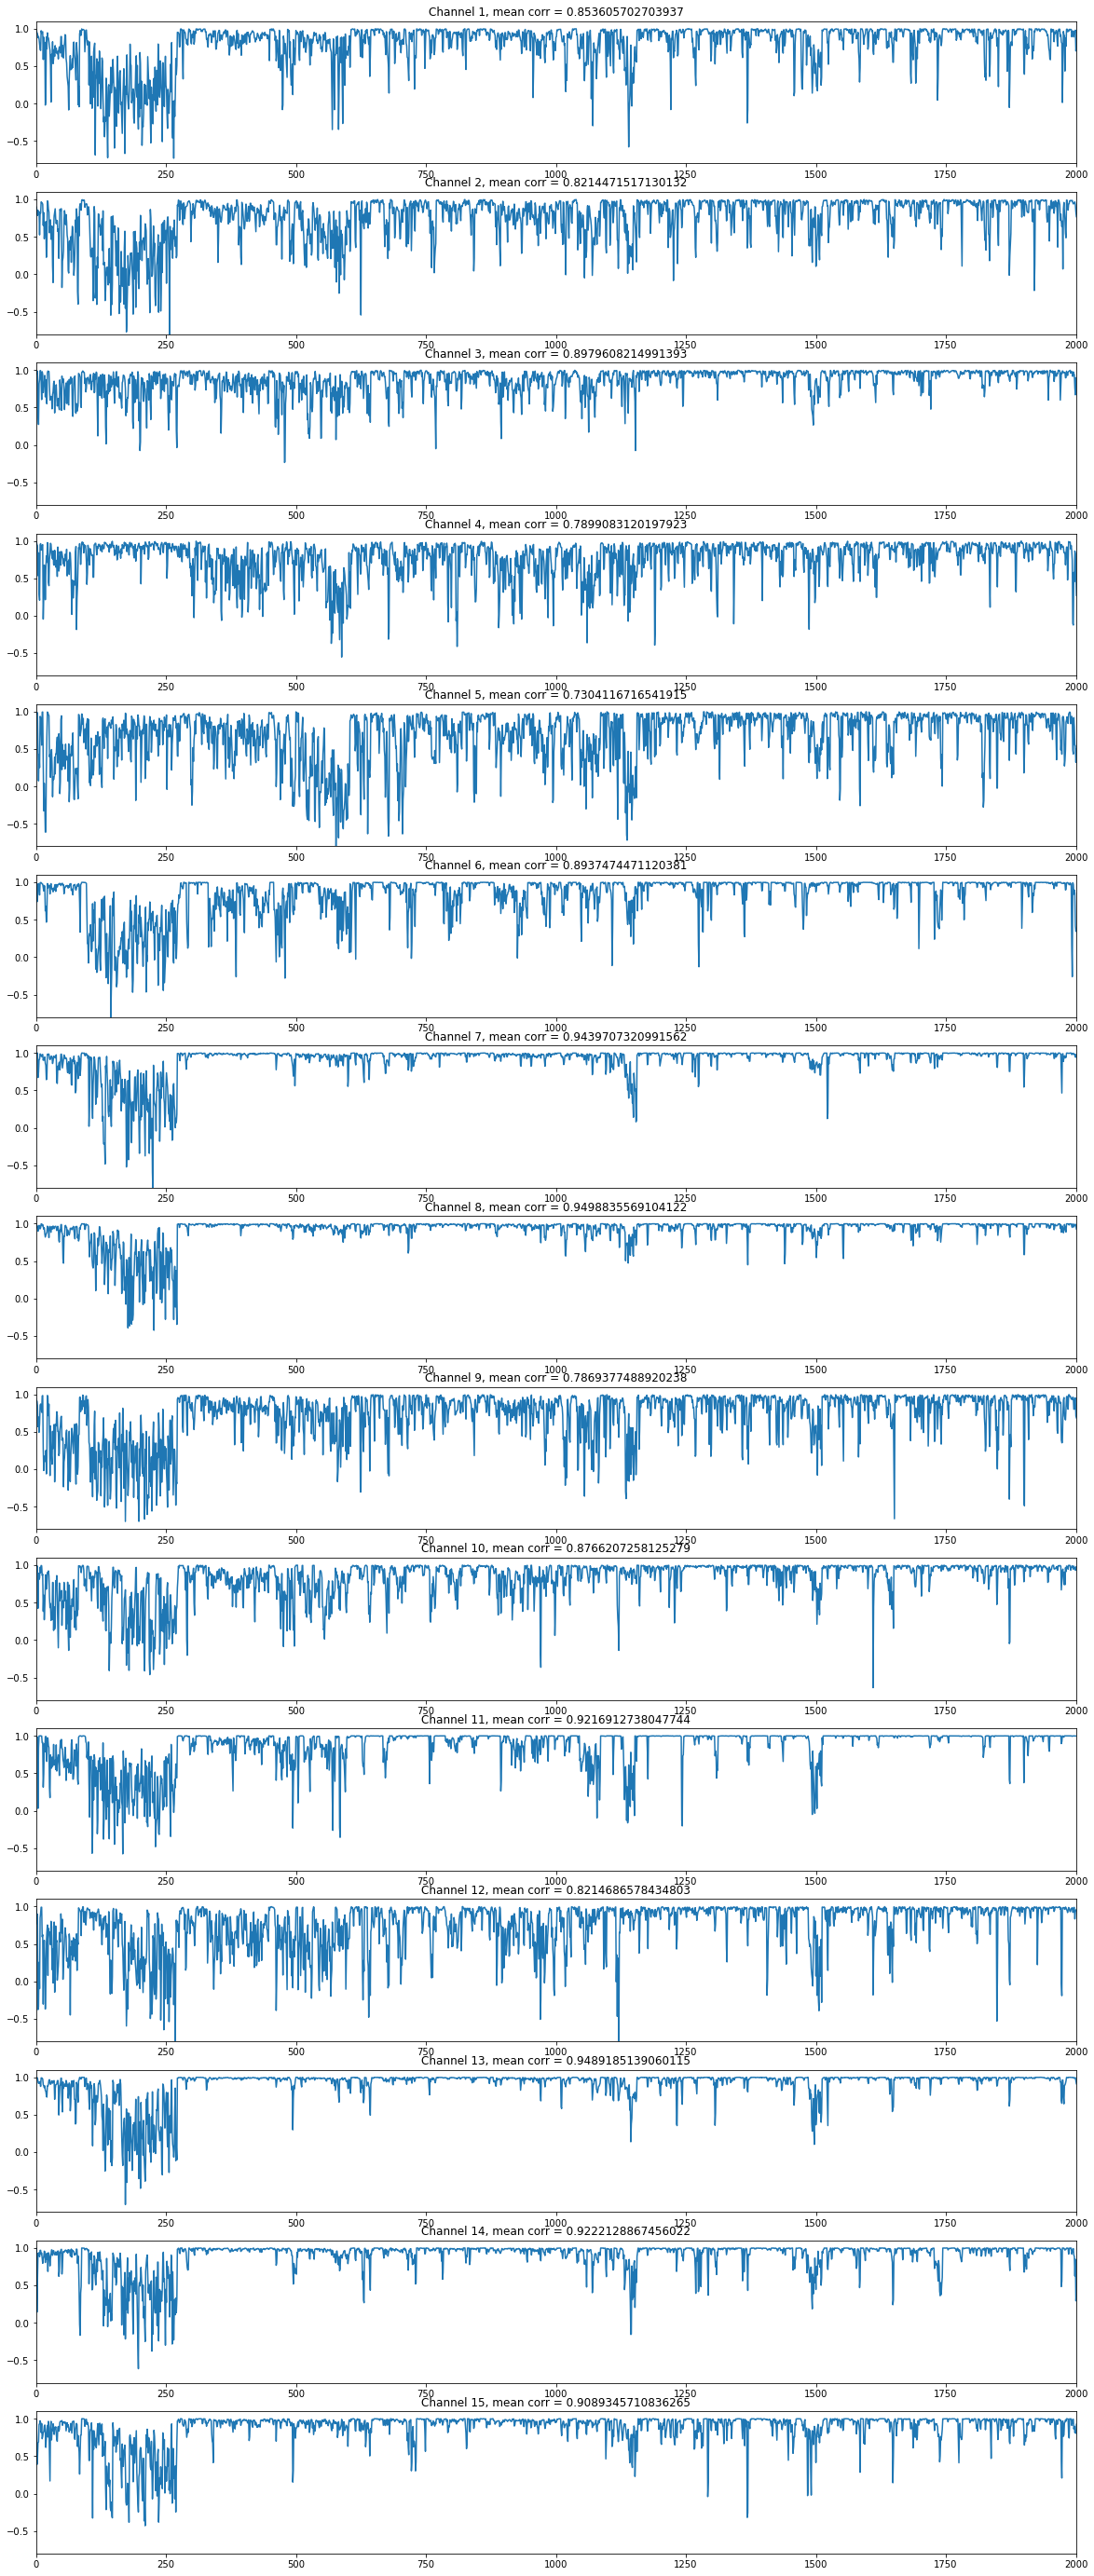

In [245]:
fig, axs = plt.subplots(number_of_features, 1, figsize = (20, 50))
for ii in range(number_of_features):
    axs[ii].plot(corr[ii])
    axs[ii].set_title(f'Channel {ii+1}, mean corr = {np.mean(corr[ii])}')
    axs[ii].set_ylim([-0.8, 1.1])
    axs[ii].set_xlim([0, 2000])
    

In [282]:
from sklearn.metrics import mean_squared_error as mse

mse_all = []
mean_all = []
for ii in range(number_of_features):
    mse_channel = []
    mean_channel = []
    for jj in range(X_train.shape[0]):
        ori = X_train[jj, :, ii]
        rec = reconstruction[jj, :, ii]
        mean_seq = np.mean(ori)
        mse_seq = mse(ori, rec)
        mse_channel.append(mse_seq)
        mean_channel.append(mean_seq)
    mse_channel = np.array(mse_channel)
    mean_channel = np.array(mean_channel)
    print(ii)
    mse_all.append(mse_channel)
    mean_all.append(mean_channel)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


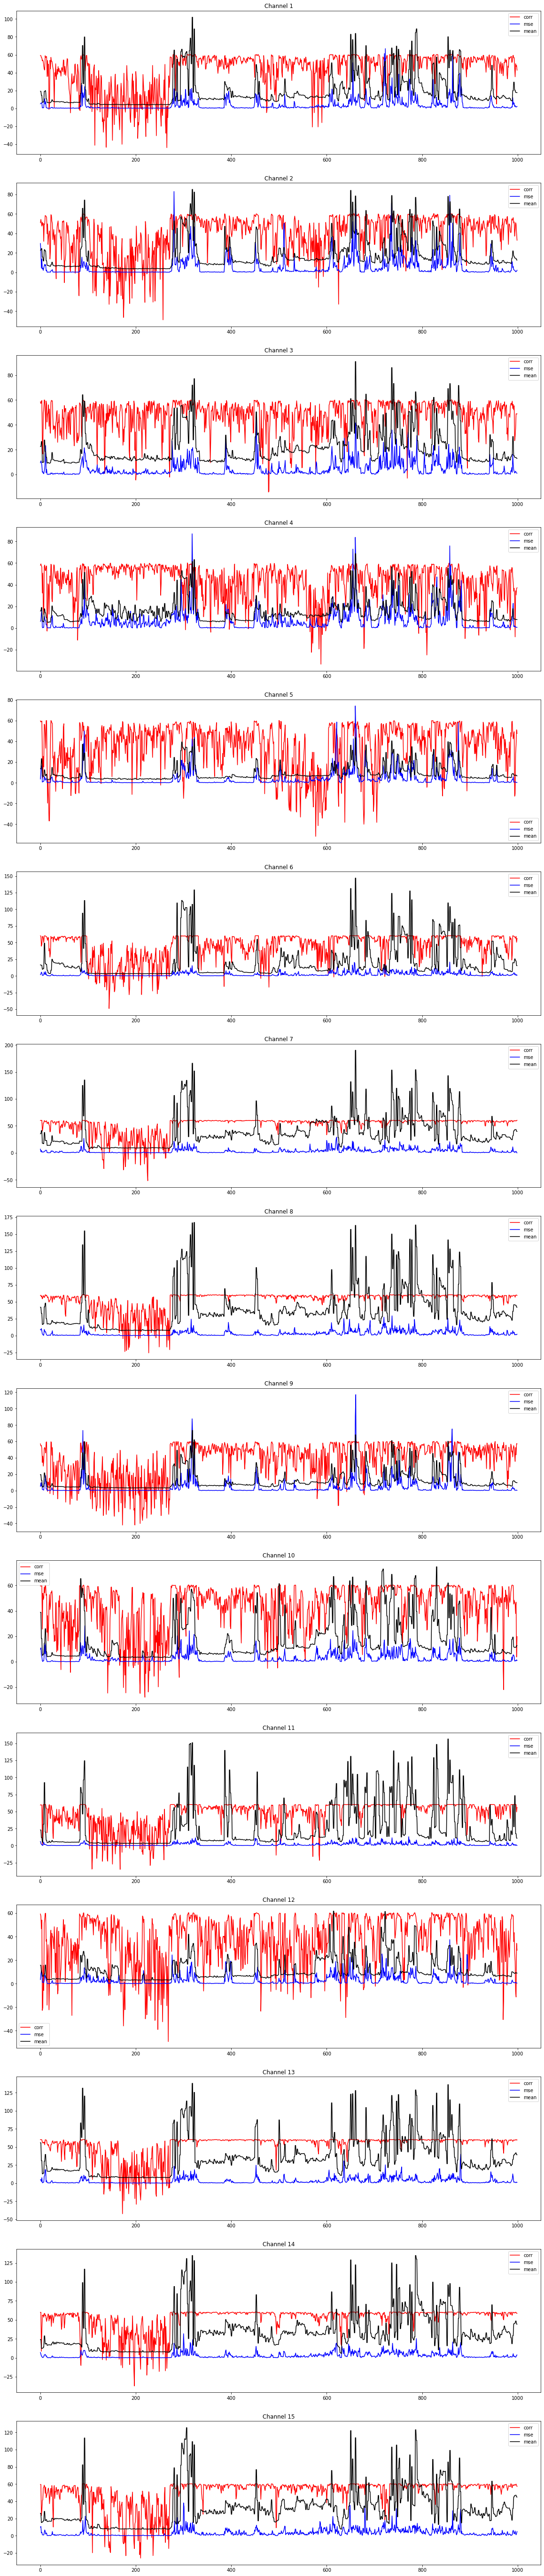

In [298]:
times = np.max(mse_all)
nn = 1000
fig, axs = plt.subplots(number_of_features, 1, figsize = (20, 100))
for ii in range(number_of_features):
    temp = np.array(corr[ii])*times/3
    axs[ii].plot(temp[:nn], color = 'r', label = 'corr')
    axs[ii].plot(mse_all[ii][:nn], color = 'b', label = 'mse')
    axs[ii].plot(mean_all[ii][:nn], color = 'k', label = 'mean')
    axs[ii].set_title(f'Channel {ii+1}')
#     axs[ii].plot(mean_all[ii][:nn]/mse_all[ii][:nn], color = 'k', label = 'mean')
    axs[ii].legend()

### Visualize using PCA and tSNE

IndexError: list index out of range

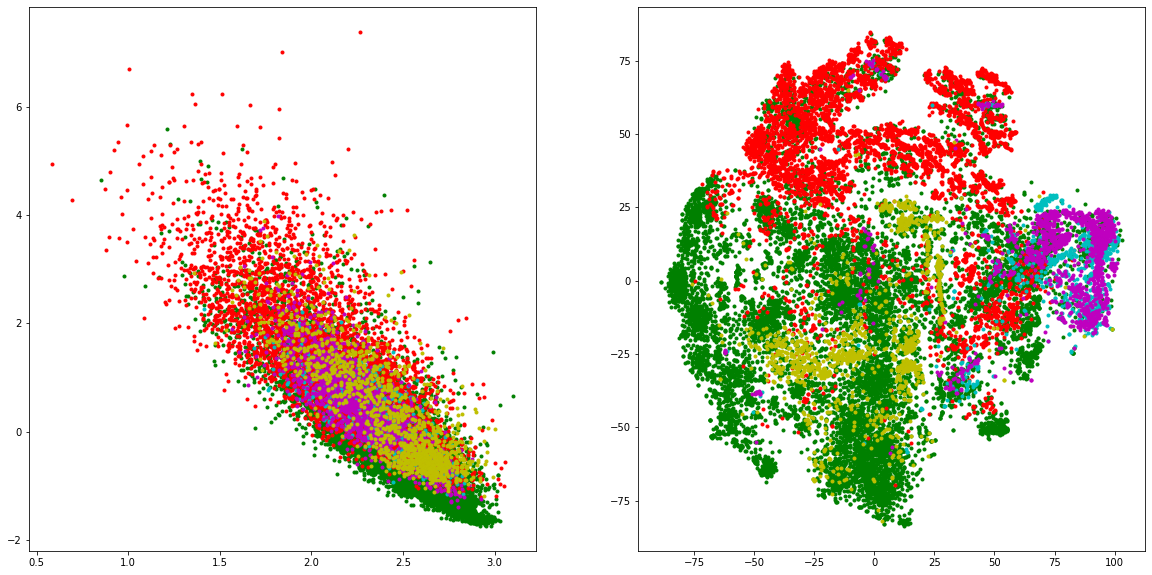

In [248]:
z_run_pca = TruncatedSVD(n_components=2).fit_transform(z_run)
z_run_tsne = TSNE(perplexity=80, min_grad_norm=1E-12, n_iter=3000).fit_transform(z_run)

all_colors = ['g','r','c','m','y']
label = y_train.transpose(1,0)

fig, axs = plt.subplots(1,2, figsize=(20,10))

for ii in range(np.unique(label).shape[0]):
    x_pca = z_run_pca[:,0].reshape(-1,1)[y_train == ii]
    y_pca = z_run_pca[:,1].reshape(-1,1)[y_train == ii]
    axs[0].scatter(x_pca, y_pca, c=all_colors[ii], marker='.', linewidths=1, label = ii)
    
    x_tsne = z_run_tsne[:,0].reshape(-1,1)[y_train == ii]
    y_tsne = z_run_tsne[:,1].reshape(-1,1)[y_train == ii]
    axs[1].scatter(x_tsne, y_tsne, c=all_colors[ii], marker='.', linewidths=1, label = ii)
    
axs[0].set_title('PCA on z_run')
axs[1].set_title('tSNE on z_run')
axs[0].legend()
axs[1].legend()
plt.show()

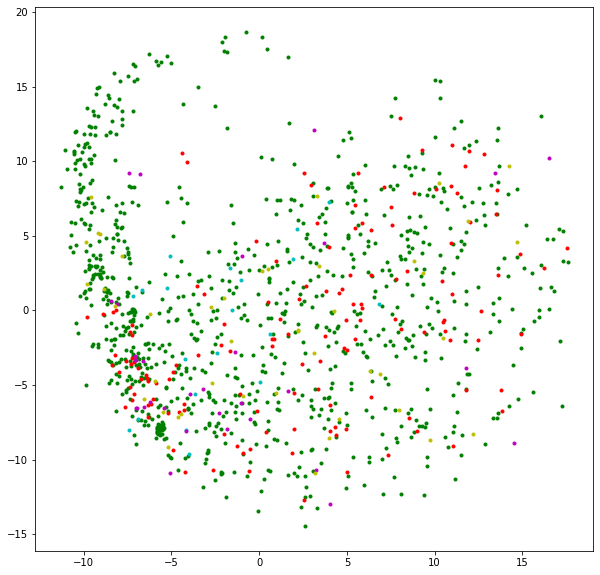

In [194]:
aaa = PCA(n_components=2).fit_transform(z_run)
all_colors = ['g','r','c','m','y']
label = y_train.transpose(1,0)

fig, axs = plt.subplots(1,1, figsize=(10,10))

for ii in range(np.unique(label).shape[0]):
    aaaa = aaa[:,0].reshape(-1,1)[y_train == ii]
    bbbb = aaa[:,1].reshape(-1,1)[y_train == ii]
    axs.scatter(aaaa, bbbb, c=all_colors[ii], marker='.', linewidths=1, label = ii)
    
#     x_tsne = z_run_tsne[:,0].reshape(-1,1)[y_train == ii]
#     y_tsne = z_run_tsne[:,1].reshape(-1,1)[y_train == ii]
#     axs[1].scatter(x_tsne, y_tsne, c=all_colors[ii], marker='.', linewidths=1, label = ii)
    
# axs[0].set_title('PCA on z_run')
# axs[1].set_title('tSNE on z_run')
# axs[0].legend()
# axs[1].legend()
plt.show()

In [47]:
# # Create clusters.annot
# from sklearn.mixture import GaussianMixture

# # Predict cluster assignments
# gm = GaussianMixture(n_components=5, random_state=0).fit(z_run)
# clusters = gm.predict(z_run)

# # Number of seconds in each sequence
# filt_time_step = 0.025
# num_secs_seq = sequence_length * filt_time_step
# end_time = len(z_run) * num_secs_seq + num_secs_seq

# # Print head of the file
# f = open ('Pop01-06_18_2021.annot','w')
# # write the header--------------------
# f.write('Bento annotation file\n')
# f.write('Movie file(s): {}\n\n'.format('Pop_20210618_cage_C1_01.avi'))
# f.write('{0} {1}\n'.format('Stimulus name:',''))
# f.write('{0} {1}\n'.format('Annotation start frame:',1))
# f.write('{0} {1}\n'.format('Annotation stop frame:', 26994))
# f.write('{0} {1}\n'.format('Annotation framerate:', 30))

# f.write('\n{0}\n'.format('List of channels:'))
# channels = ['cluster_num']
# for item in channels:
#         f.write('{0}\n'.format(item))
# f.write('\n');

# f.write('{0}\n'.format('List of annotations:'))
# clust_names = ['cluster_{}'.format(str(num)) for num in set(clusters)]
# labels = clust_names
# # labels = [item.replace(' ','_') for item in labels]
# for item in labels:
#     f.write('{0}\n'.format(item))
# f.write('\n')

# # now write the contents---------------
# for ch in channels:
#     f.write('{0}----------\n'.format(ch))
#     for beh in labels:
#         f.write('>{0}\n'.format(beh))
#         f.write('{0}\t {1}\t {2} \n'.format('Start','Stop','Duration'))

#         idxs = np.where(clusters == int(beh.split('_')[-1]))[0]
#         for hit in idxs:
#             start_time = hit * num_secs_seq/2
#             end_time = start_time + num_secs_seq
#             f.write('{0}\t{1}\t{2}\n'.format(start_time, end_time, num_secs_seq))
#         f.write('\n')
#     f.write('\n')

# f.close()